## Comparing LoRA and DoRA (Weighted decomposition of LoRA)

#### **<font color=yellow>First let's look into LoRA - (Low Rank Adaptation of Pretrained Weights)**

In [1]:
import torch
import torch.nn as nn

import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from transformers import AutoModelForCausalLM
from peft import PeftModel

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def load_model(model_name):
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float32, device_map="auto")
    model.eval()
    return model

In [3]:
def weight_decomposition(weights, store: dict, tag=None):
    for i in range(len(weights)):
        magnitude = weights[i].norm(p=2, dim=1, keepdim=True)
        direction = weights[i] / magnitude
        store[f"query_layer_{i}"].append(magnitude)
        store[f"query_layer_{i}"].append(direction)


def get_model_weights(model, tag=None):
    query_weights = []
    for layer in model.model.model.layers:
        query_weights.append(layer.self_attn.v_proj.base_layer.weight)
    return query_weights

In [4]:
# Load the finetuned model from Hugging face or local disk
model_name = "meta-llama/Llama-2-7b-hf"
peft_name = "trl/output/dora/checkpoint-100"

model = load_model(model_name)
peft_model = PeftModel.from_pretrained(model, peft_name)
# merged_model = peft_model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
pretrained_weight_decomposition = defaultdict(list)
pretrained_query_weights = get_model_weights(peft_model)
weight_decomposition(pretrained_query_weights, pretrained_weight_decomposition)

# del merged_model
del peft_model

In [ ]:
# from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

# peft_config = LoraConfig(
#     use_dora=True,
#     r=64,
#     lora_alpha=128,
#     lora_dropout=0.0,
#     target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
#     bias="none",
#     task_type="CAUSAL_LM",
#     inference_mode=True
# )

# model = get_peft_model(model, peft_config)
# model.print_trainable_parameters()

In [ ]:
# for i in merged_model.model.layers:
#     print(i.self_attn.q_proj.weight)
# print(i.self_attn.q_proj.base_layer.weight.shape)
# print(i.self_attn.q_proj.lora_A.default.weight.shape)
# print(i.self_attn.q_proj.lora_B.default.weight.shape)
# break

In [37]:
def merged_dora_weights(layer):
    combined_weights = layer.weight
    return combined_weights


def get_merged_weights(model, tag=None):
    query_weights = []
    for layer in model.model.layers:
        query_weights.append(merged_dora_weights(layer.self_attn.v_proj))
    return query_weights


def merged_lora_weights(layer):
    alpha = 2 * layer.lora_A.default.weight.shape[0]
    lora_weights = layer.lora_A.default.weight.T @ layer.lora_B.default.weight.T
    combined_weights = layer.base_layer.weight + alpha*lora_weights
    return combined_weights


def delta_magnitude(pt_weights, ft_weights):
    layer_wise_delta_m = {}
    for i in range(1, 32, 6):
        a = ft_weights.get(f"query_layer_{i}")[0]
        b = pt_weights.get(f"query_layer_{i}")[0]
        k = b.shape[0]
        d_m = torch.sum(abs(a - b)) / k
        layer_wise_delta_m[f"layer_{i}"] = round(d_m.item(), 6)
    return layer_wise_delta_m


def delta_direction(pt_weights, ft_weights):
    layer_wise_delta_d = {}
    for i in range(1, 32, 6):
        a = ft_weights.get(f"query_layer_{i}")[1]
        b = pt_weights.get(f"query_layer_{i}")[1]
        k = b.shape[0]
        sim = torch.nn.functional.cosine_similarity(a.t(), b.t(), dim=1)
        d_m = torch.sum(1 - sim) / k
        layer_wise_delta_d[f"layer_{i}"] = round(d_m.item(), 6)
    return layer_wise_delta_d

In [38]:
def get_magnitude_directions(tag):
    checkpoint_path = "trl/output/dora"
    artifacts = os.listdir(checkpoint_path)
    combined_dm, combined_dd = defaultdict(list), defaultdict(list)

    for model_dir in artifacts:
        if not model_dir.startswith("."):
            decomposed_weights = defaultdict(list)
            model_path = os.path.join(checkpoint_path, model_dir)
            peft_model = PeftModel.from_pretrained(model, model_path)
            merged_model = peft_model.merge_and_unload()
            query_weights = get_merged_weights(merged_model)
            del peft_model
            del merged_model

            weight_decomposition(query_weights, decomposed_weights, tag=tag)
            dm = delta_magnitude(pretrained_weight_decomposition, decomposed_weights)
            dd = delta_direction(pretrained_weight_decomposition, decomposed_weights)

            name = model_dir[-3:]
            combined_dm[name].append(dm)
            combined_dd[name].append(dd)
    return combined_dm, combined_dd

In [39]:
tag = "dora"
dora_m, dora_d = get_magnitude_directions(tag=tag)

In [40]:
# Accumulate magnitude and direction of each checkpoint layer wise for plotting
ckpt_wise_m_d = []
for model_name in ['200', '400', '600', '700', 'nal']:
    if model_name in dora_m and model_name in dora_d:
        magnitude, direction = dora_m[model_name], dora_d[model_name]
        k = 0
        layer_wise_m_d = {}
        for m, d in zip(magnitude[0].items(), direction[0].items()):
            layer_wise_m_d[f"layer_{k}"] = {"m": m[1], "d": d[1]}
            k += 1
        ckpt_wise_m_d.append(layer_wise_m_d)

In [41]:
ckpt_wise_m_d

[{'layer_0': {'m': 0.002887, 'd': 0.651256},
  'layer_1': {'m': 0.003529, 'd': 0.677935},
  'layer_2': {'m': 0.003704, 'd': 0.55583},
  'layer_3': {'m': 0.004092, 'd': 0.505337},
  'layer_4': {'m': 0.003753, 'd': 0.364676},
  'layer_5': {'m': 0.003984, 'd': 0.471588}},
 {'layer_0': {'m': 0.004833, 'd': 0.712438},
  'layer_1': {'m': 0.004599, 'd': 0.735603},
  'layer_2': {'m': 0.004681, 'd': 0.619383},
  'layer_3': {'m': 0.004992, 'd': 0.573016},
  'layer_4': {'m': 0.004601, 'd': 0.422093},
  'layer_5': {'m': 0.004985, 'd': 0.533304}},
 {'layer_0': {'m': 0.005097, 'd': 0.699372},
  'layer_1': {'m': 0.004841, 'd': 0.723488},
  'layer_2': {'m': 0.004943, 'd': 0.606114},
  'layer_3': {'m': 0.005238, 'd': 0.558848},
  'layer_4': {'m': 0.004757, 'd': 0.409947},
  'layer_5': {'m': 0.005256, 'd': 0.520012}},
 {'layer_0': {'m': 0.005126, 'd': 0.669573},
  'layer_1': {'m': 0.004853, 'd': 0.69528},
  'layer_2': {'m': 0.004944, 'd': 0.575376},
  'layer_3': {'m': 0.005244, 'd': 0.525481},
  'layer_

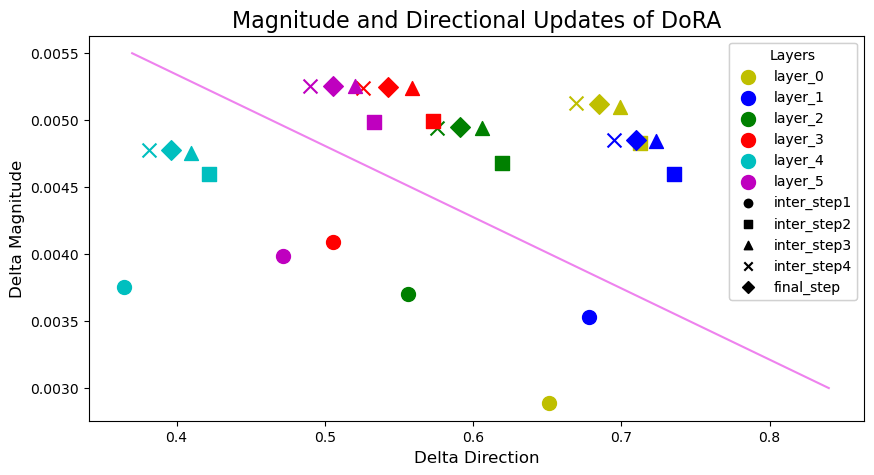

In [46]:
layers = ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5']
markers = ['o', 's', '^', 'x', 'D']
colors = ['y', 'b', 'g', 'r', 'c', 'm']
marker_labels = ["inter_step1",  "inter_step2", "inter_step3", "inter_step4", "final_step"]

plt.figure(figsize=(10, 5))

for i, layer in enumerate(layers):
    for j, entry in enumerate(ckpt_wise_m_d):
        plt.scatter(entry[layer]['d'], entry[layer]['m'], color=colors[i], label=layer if j == 0 else "", marker=markers[j], s=100)

for i, marker in enumerate(markers):
    plt.scatter([], [], marker=marker, color='k', label=marker_labels[i])

x = np.linspace(0.37, 0.84, 100)
y = np.linspace(0.003, 0.0055, 100)[::-1]
plt.plot(x, y, '-', color='violet')

legend_layers = plt.legend(title='Layers', loc='upper right')
plt.gca().add_artist(legend_layers)

plt.xlabel('Delta Direction', fontsize=12)
plt.ylabel('Delta Magnitude', fontsize=12)
plt.title('Magnitude and Directional Updates of DoRA', fontsize=16)
plt.grid(False)

# plt.savefig('plot_dora_v_proj.jpg', format='jpg')
plt.show()